In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils import generate_data_object_synthetic

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def line_plot_with_std(list_scores, fname):

    # Convert the list of lists to a Pandas DataFrame
    df = pd.DataFrame(list_scores)

    # Calculate the mean and standard deviation of each row
    mean = df.mean(axis=1)
    std = df.std(axis=1)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean, color='blue', label='Mean')

    # Plot the shaded region around the mean line
    ax.fill_between(df.index, mean-std, mean+std, color='lightblue', alpha=0.5, label='Standard deviation')

    # Add some labels and a legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()

    # Show and save the plot
    plt.grid()
    plt.xlabel('Number of tasks per student')
    plt.ylabel('Balanced Accuracy')
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [3]:
from IPython.utils import io
import matplotlib.pyplot as plt

import string
def create_filename_results(parameters,fold):
    file_name = ' '.join([f"{str(key)}-{str(value)}" for key, value in parameters.items() if key not in ['max_n_tasks_per_student','min_n_tasks_per_student']])
    file_name += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(4))
    file_name.replace(".","")
    file_name+=".results"
    return os.path.join(fold, file_name)


#n_students_per_task_list = [2**i for i in n_students_per_task_list]

import json
def synthetic_density_effect_runs(parameters,parameters_density, folder = 'synth_density_effect'):
    parameters = {**parameters, **parameters_density}
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    scores = []
    list_scores = []
    for n_task_per_student in tqdm(n_tasks_per_student_list):
        with io.capture_output() as captured:
            data = generate_data_object_synthetic(
                n_students = parameters['n_students'], # 72% of nodes were students
                n_tasks = parameters['n_tasks'],
                n_task_per_student = n_task_per_student,
                error_proness_denom = parameters['error_proness_denom'],
                probabilistic = parameters['probabilistic'],
                number_of_tasks_per_students_is_max=parameters['number_of_tasks_per_students_is_max'])

            cv_out = perform_cross_validation(data, parameters)
            score = 0
            inner_list_scores = []
            for fold_n in range(parameters["n_splits"]):
                score += cv_out[f"Balanced Accuracy_{fold_n}_test"]
                inner_list_scores.extend([cv_out[f"Balanced Accuracy_{fold_n}_test"]])
            score = score / parameters["n_splits"]
            scores.append(score)
            list_scores.append(inner_list_scores)

    res_dict = dict(zip(n_tasks_per_student_list,scores))
    output_dict = {
        **parameters,
        "res_dict":res_dict,
        "list_scores":dict(zip(n_tasks_per_student_list,list_scores))
    }
    fname = create_filename_results(parameters_density, folder)
    with open(fname,'w') as f:
        json.dump(output_dict, f, skipkeys=True)
    
    # save results
    line_plot_with_std(list_scores=list_scores, fname=fname)


In [4]:
parameters = {
    "hidden_dims": [16, 8],
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 10000,
    "learning_rate": 0.005,
    "weight_decay": 0,
    "dropout": 0.4,
    "early_stopping": 200,
    "n_splits": 3,
    "device": "cuda",
    "done": False,
    "batch_size":128,
    #
    }

parameters_density = {
    'n_students' :720, # 72% of nodes were students
    'n_tasks':280,
    'max_n_tasks_per_student':280, 
    'min_n_tasks_per_student':5,
    'step_n_tasks_per_student':10,
    'error_proness_denom':None,
    'probabilistic':None,
    'number_of_tasks_per_students_is_max':None
}


 64%|██████▍   | 18/28 [00:05<00:02,  3.58it/s]


KeyboardInterrupt: 

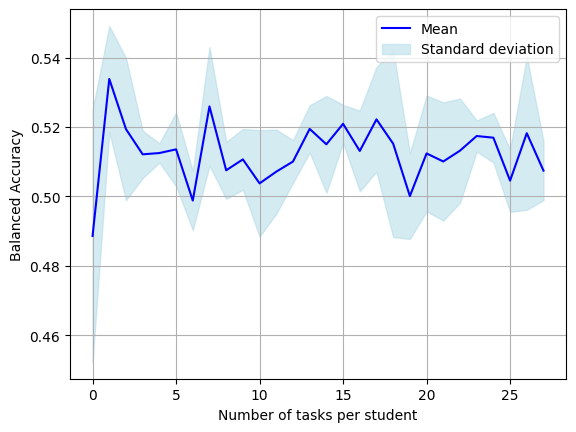

In [5]:
for probabilities in [0,1]:
    for error_proness_denom in [1,2,3]:
        for number_of_tasks_per_students_is_max in [0,1]:
            parameters_density['probabilistic'] = probabilities
            parameters_density['error_proness_denom'] = error_proness_denom
            parameters_density['number_of_tasks_per_students_is_max'] = number_of_tasks_per_students_is_max
            synthetic_density_effect_runs(parameters=parameters,
                                          parameters_density=parameters_density,
                                          )